In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [59]:
# import the raw dataset
df = pd.read_csv("rawdata.csv")

In [60]:
# calculate the average repetitations of each date
np.mean(df.groupby("Date").size())

39.79706445437141

In [61]:
# calculate the label
df["next_day"] = df["Close"].shift(-1)

df["target"] = (df["next_day"] > df["Close"]).astype(int)

def remove_last_row(group):
    return group.iloc[:-1]

df = df.groupby("ETFs_index").apply(remove_last_row).reset_index(drop=True)

df

,Date,Open,High,Low,Close,Volume,OpenInt,ETFs_index,next_day,target
0,2007-10-30,49.70,49.7000,49.700,49.70,100,0,0,50.00,1
1,2007-10-31,49.68,50.0000,49.680,50.00,4700,0,0,49.13,0
2,2007-11-01,49.36,49.3600,49.100,49.13,19100,0,0,49.05,0
3,2007-11-02,49.25,49.2500,49.050,49.05,4300,0,0,48.94,0
4,2007-11-05,48.94,48.9400,48.940,48.94,100,0,0,49.66,1
...,...,...,...,...,...,...,...,...,...,...
186981,2017-11-03,27.25,27.3400,26.880,26.94,125436,0,99,27.39,1
186982,2017-11-06,27.19,27.4799,27.050,27.39,85751,0,99,27.35,0
186983,2017-11-07,27.31,27.4500,27.309,27.35,130632,0,99,28.23,1
186984,2017-11-08,27.49,28.3550,27.490,28.23,298575,0,99,28.49,1


In [62]:
# sort the data and remove irrelevant features
df = df.sort_values(by="Date")

df = df.drop("OpenInt", axis=1)

# df = df.drop("ETFs_index", axis=1)

df = df.drop("next_day", axis=1)

df.set_index("Date", inplace=True)

df

,Open,High,Low,Close,Volume,ETFs_index,target
Date,,,,,,,
1999-03-10,45.722,45.7500,44.967,45.6650,11700414,40,1
1999-03-11,45.994,46.2600,44.988,45.8800,21670048,40,0
1999-03-12,45.721,45.7490,44.406,44.7700,19553768,40,1
1999-03-15,45.101,46.1030,44.625,46.0520,14245348,40,1
1999-03-16,46.253,46.6430,45.749,46.4470,10971066,40,0
...,...,...,...,...,...,...,...
2017-11-09,67.190,67.1900,66.370,67.0700,1961179,8,1
2017-11-09,13.500,13.5500,13.475,13.5400,162075,71,0
2017-11-09,14.460,14.5868,14.460,14.5001,9162,12,1


In [63]:
# # this is used for result analysis and discussion, not the optimal dataset
# # output dataset: raw
# training_size = int(len(df) * 0.8)
# test_size = df.shape[0] - training_size

# xTrain = df.drop("target", axis=1).iloc[:training_size]
# xTest = df.drop("target", axis=1).iloc[-1 * test_size:]

# yTrain_discrete = df["target"].iloc[:training_size]
# yTest_discrete = df["target"].iloc[-1 * test_size:]

# scalar1 = StandardScaler()

# xTrain = scalar1.fit_transform(xTrain)
# xTest = scalar1.transform(xTest)

# pd.DataFrame(xTrain).to_csv("preprocessed_data/xTrain.csv", index=False)
# pd.DataFrame(xTest).to_csv("preprocessed_data/xTest.csv", index=False)

# pd.DataFrame(yTrain_discrete).to_csv("preprocessed_data/yTrain_discrete.csv", index=False)
# pd.DataFrame(yTest_discrete).to_csv("preprocessed_data/yTest_discrete.csv", index=False)

In [64]:
# feature extraction
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = df.rolling(horizon * 39).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    df[ratio_column] = df["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    df[trend_column] = df.shift(1).rolling(horizon * 39).sum()["target"]
    
    new_predictors+= [ratio_column, trend_column]
    
df = df.dropna()

df

,Open,High,Low,Close,Volume,ETFs_index,target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2010-08-06,39.240,39.2400,38.830,39.1500,3030,0,1,1.084074,37.0,1.106507,90.0,1.092566,1229.0,1.028655,5053.0,1.056832,19914.0
2010-08-06,209.850,211.8000,206.800,207.5500,47691,26,1,5.390895,37.0,5.705599,90.0,5.781958,1230.0,5.450793,5054.0,5.602066,19914.0
2010-08-06,96.467,96.5460,96.314,96.3620,12049,49,1,2.502607,38.0,2.620646,91.0,2.682057,1231.0,2.530414,5055.0,2.600853,19915.0
2010-08-06,30.421,30.9500,30.166,30.9230,96770,36,1,0.799377,38.0,0.840343,92.0,0.860760,1232.0,0.812056,5055.0,0.834634,19915.0
2010-08-06,9.516,9.6460,9.516,9.6460,504,71,0,0.249476,38.0,0.262139,93.0,0.268605,1233.0,0.253488,5055.0,0.260359,19915.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-09,67.190,67.1900,66.370,67.0700,1961179,8,1,1.287979,31.0,1.275114,66.0,1.301645,1188.0,1.342359,5297.0,1.428174,20548.0
2017-11-09,13.500,13.5500,13.475,13.5400,162075,71,0,0.262483,31.0,0.257756,66.0,0.262907,1189.0,0.271002,5297.0,0.288319,20549.0
2017-11-09,14.460,14.5868,14.460,14.5001,9162,12,1,0.281760,31.0,0.276321,65.0,0.281690,1188.0,0.290228,5296.0,0.308770,20549.0


Feature selection

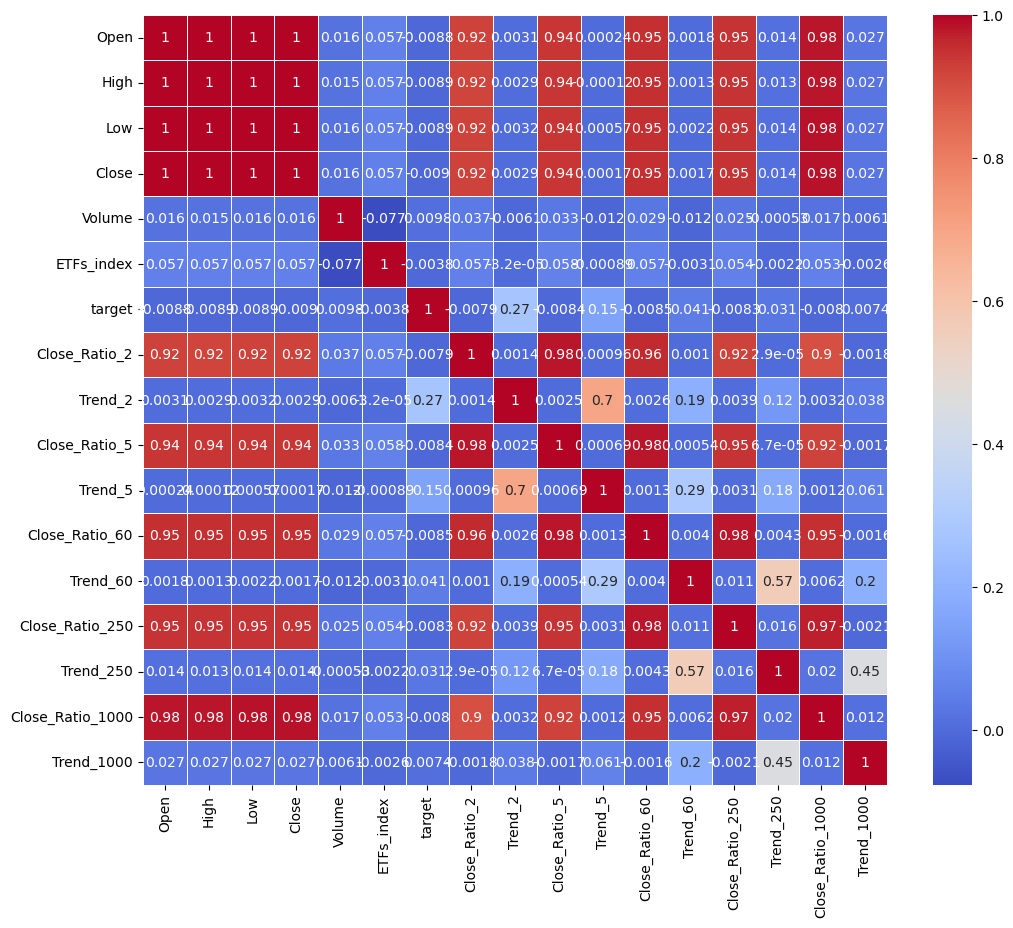

In [65]:
# analyze current correlation
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.show()

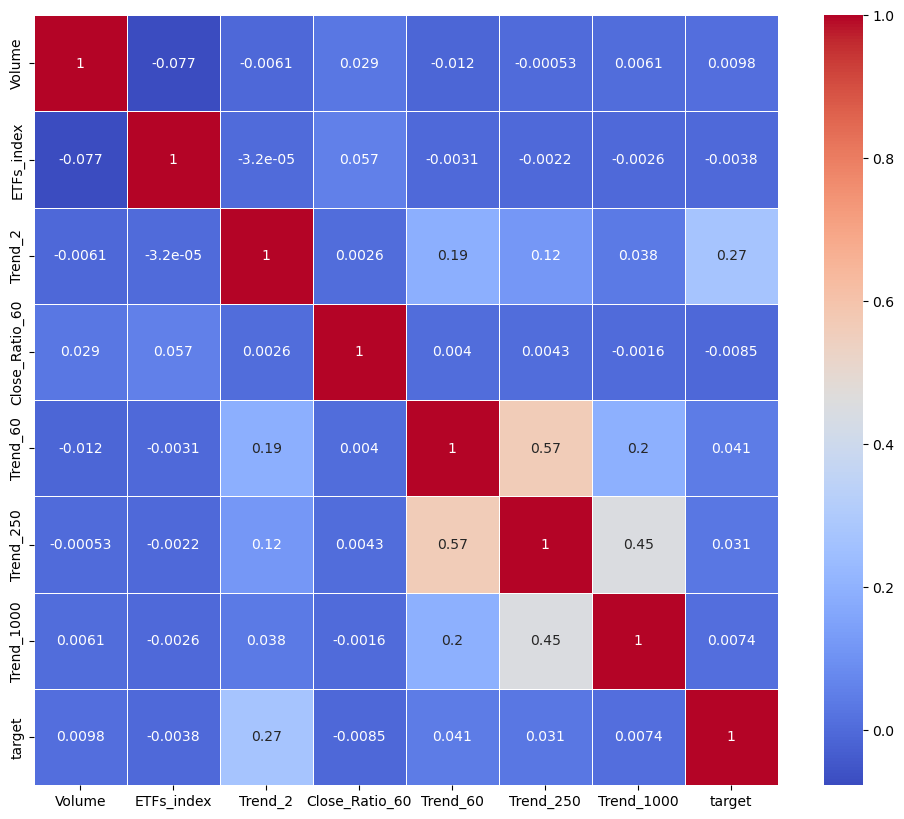

In [66]:
# check correlation heatmap after selecting certain features
selected_features = ['Volume', 'ETFs_index',
       'Trend_2',
       'Close_Ratio_60', 'Trend_60', 'Trend_250',
       'Trend_1000', 'target']

partial_corr_matrix = df[selected_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(partial_corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.show()

In [67]:
# check null values
print(df.isnull().sum())

Open                0
High                0
Low                 0
Close               0
Volume              0
ETFs_index          0
target              0
Close_Ratio_2       0
Trend_2             0
Close_Ratio_5       0
Trend_5             0
Close_Ratio_60      0
Trend_60            0
Close_Ratio_250     0
Trend_250           0
Close_Ratio_1000    0
Trend_1000          0
dtype: int64


In [68]:
# output datasets: raw + feature expansion + feature selected
features = ['Volume', 'Trend_2', 'ETFs_index',
       'Close_Ratio_60', 'Trend_60', 'Trend_250',
       'Trend_1000']

training_size = int(len(df) * 0.8)
test_size = df.shape[0] - training_size

xTrain = df[features].iloc[:training_size]
xTest = df[features].iloc[-1 * test_size:]

yTrain_discrete = df["target"].iloc[:training_size]
yTest_discrete = df["target"].iloc[-1 * test_size:]

scalar1 = StandardScaler()

xTrain = scalar1.fit_transform(xTrain)
xTest = scalar1.transform(xTest)

pd.DataFrame(xTrain, columns=features).to_csv("preprocessed_data/xTrain.csv", index=False)
pd.DataFrame(xTest, columns=features).to_csv("preprocessed_data/xTest.csv", index=False)

pd.DataFrame(yTrain_discrete).to_csv("preprocessed_data/yTrain_discrete.csv", index=False)
pd.DataFrame(yTest_discrete).to_csv("preprocessed_data/yTest_discrete.csv", index=False)

In [69]:
# # output datasets: raw + feature expansion. This is used 
# training_size = int(len(df) * 0.8)
# test_size = df.shape[0] - training_size

# xTrain = df.drop("target", axis=1).iloc[:training_size]
# xTest = df.drop("target", axis=1).iloc[-1 * test_size:]

# yTrain_discrete = df["target"].iloc[:training_size]
# yTest_discrete = df["target"].iloc[-1 * test_size:]

# scalar1 = StandardScaler()

# xTrain = scalar1.fit_transform(xTrain)
# xTest = scalar1.transform(xTest)

# pd.DataFrame(xTrain).to_csv("preprocessed_data/xTrain.csv", index=False)
# pd.DataFrame(xTest).to_csv("preprocessed_data/xTest.csv", index=False)

# pd.DataFrame(yTrain_discrete).to_csv("preprocessed_data/yTrain_discrete.csv", index=False)
# pd.DataFrame(yTest_discrete).to_csv("preprocessed_data/yTest_discrete.csv", index=False)